# Setup

In [ ]:
# Set up dependencies

from google.colab import drive
drive.mount('/content/drive/')

! pip install -U torch
! pip install -U transformers
! pip install -U datasets
! pip install sentencepiece
! pip install transformers[torch]
! pip install numba

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta

In [ ]:
# # Libraries

import pickle
import numpy as np
import pandas as pd
from numba import cuda

import torch
import transformers

from sklearn.metrics import mean_squared_error
from datasets import Dataset, load_dataset, load_from_disk, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Train

In [ ]:
# Dataframe

dataframe = pd.read_feather('/content/drive/MyDrive/scraped_goldstein_filtered.fthr')
dataframe = dataframe.drop_duplicates(subset = ['SOURCEURL'])
dataframe = dataframe.drop(['SOURCEURL'], axis = 1)
dataframe = dataframe.rename(columns = {'GoldsteinScale':'label', 'Text':'text'})
dataframe = dataframe.sample(frac = 1)
dataframe = dataframe[['label', 'text']].reset_index(drop = True)

dataset = Dataset.from_pandas(dataframe, preserve_index = False)
dataset = dataset.train_test_split(test_size = 0.15)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 15318
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 2704
    })
})

In [ ]:
# Functions

def tokenize_function(examples):

    return tokenizer(examples["text"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)

    return {"rmse": rmse}

In [ ]:
# Set up model and tokenizer

# Get tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

# Tokenize text
tokenized_datasets = dataset.map(tokenize_function, batched = True)

# Get model
model = AutoModelForSequenceClassification.from_pretrained('roberta-large', num_labels = 1)

# Resize by tokens
model.resize_token_embeddings(len(tokenizer))

In [ ]:
# Set up trainer

# Get trainer arguments
training_args = TrainingArguments(output_dir = "test_trainer",
                                  logging_strategy = "epoch",
                                  evaluation_strategy = "epoch",
                                  num_train_epochs = 3,
                                  save_total_limit = 2,
                                  save_strategy = 'no',
                                  load_best_model_at_end = False)

# Get trainer
trainer = Trainer(model = model,
                  args = training_args,
                  train_dataset = tokenized_datasets["train"],
                  eval_dataset = tokenized_datasets["test"],
                  compute_metrics = compute_metrics)

In [ ]:
# Train

trainer.train()

Epoch,Training Loss,Validation Loss,Rmse
1,14.698600,14.983284,3.870825
2,14.611400,14.909249,3.861250
3,14.563300,14.912086,3.861617


TrainOutput(global_step=5745, training_loss=14.624424091601393, metrics={'train_runtime': 3585.1332, 'train_samples_per_second': 12.818, 'train_steps_per_second': 1.602, 'total_flos': 4.282582917041971e+16, 'train_loss': 14.624424091601393, 'epoch': 3.0})

In [ ]:
# save the model/tokenizer

model.save_pretrained("/content/drive/MyDrive/goldstein_regression_model")

tokenizer.save_pretrained("/content/drive/MyDrive/goldstein_regression_tokenizer")

# Test

In [ ]:
# Get tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/tokenizer2/')

# Get model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/model2/', num_labels = 1)
trainer = Trainer(model = model)

In [ ]:
with open('/content/drive/MyDrive/model_extracted_oil_triples.pickle', 'rb') as handle:

    triples = pickle.load(handle)

In [ ]:
def tokenize_function(examples):

    return tokenizer(examples["text"], padding="max_length", truncation=True)

def pipeline_prediction(text, trainer):

    df = pd.DataFrame({'text':text})

    dataset = Dataset.from_pandas(df, preserve_index=False)

    tokenized_datasets = dataset.map(tokenize_function)

    raw_pred, _, _ = trainer.predict(tokenized_datasets)

    return raw_pred

In [ ]:
pred_scores = pipeline_prediction(dataset['test']['text'], trainer)
pred_scores = [elm[0] for elm in pred_scores]

real_scores = dataset['test']['label']

Map:   0%|          | 0/2704 [00:00<?, ? examples/s]

In [ ]:
performance_df = pd.DataFrame(data = [pred_scores, real_scores], index = ['pred', 'real']).T

In [ ]:
abs(performance_df['real'] - performance_df['pred']).mean()

1.4404073630632943

In [ ]:
performance_df['diff'] = performance_df['real'] - performance_df['pred']

<Axes: >

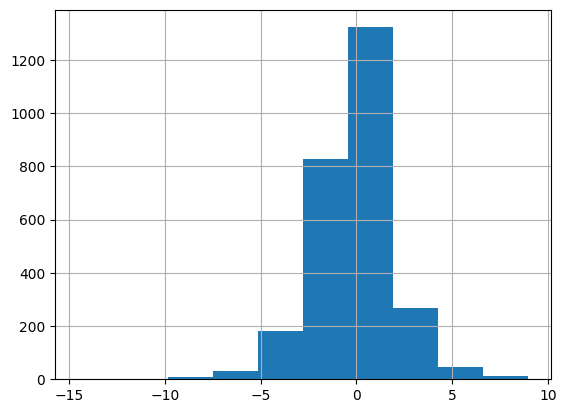

In [ ]:
performance_df['diff'].hist()

In [ ]:
device = cuda.get_current_device()
device.reset()

# Apply

In [ ]:
test_texts = dataset['test']['text']

In [ ]:
sample = "Exxon mobil is suing Russia for its actions."#test_texts[121]
pred_scores = pipeline_prediction([sample], trainer)
pred_scores = [elm[0] for elm in pred_scores][0]
pred_scores

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

-4.563899